In [1]:
from datasets import load_dataset

dataset_name = "batterydata/pos_tagging"
training_dataset = load_dataset(dataset_name, split="train")
test_dataset = load_dataset(dataset_name, split="test")


In [2]:
training_dataset


Dataset({
    features: ['words', 'labels'],
    num_rows: 13054
})

In [3]:
test_dataset


Dataset({
    features: ['words', 'labels'],
    num_rows: 1451
})

So for data preprocessing:
1. Make words to idx and labels to idx dictionaries
2. Make a validation split from the training set
3. Encode all the data with indices found from 1

In [4]:
# a dict containing word -> idx mapping
def create_word_indices(dataset):
    unique_words = set()
    word_to_idx = dict()
    # add an out of vocab token
    oov_token = "<OOV>"
    pad_token = "<PAD>"
    word_to_idx[oov_token] = 0
    word_to_idx[pad_token] = 1
    
    # find unique words
    for data in dataset:
        words = data["words"]
        for w in words:
            unique_words.add(w)
            
    # add index to them
    for idx, uw in enumerate(list(unique_words)):
        word_to_idx[uw] = idx + 2 # since oov is at 0 and pad at 1
        
    
    return word_to_idx


# ===============
word_to_idx = create_word_indices(training_dataset)
len(word_to_idx)


24849

In [5]:
def create_label_to_idx(dataset):
    unique_labels = set()
    label_to_idx = dict()
    # add an out of vocab token
    oov_token = "<OOV>"
    pad_token = "<PAD>"
    label_to_idx[oov_token] = 0
    label_to_idx[pad_token] = 1
    
    # find the labels
    for data in dataset:
        labels = data["labels"]
        for l in labels:
            unique_labels.add(l)
            
    # index
    for idx, label in enumerate(list(unique_labels)):
        label_to_idx[label] = idx + 2
        
    return label_to_idx
    
label_to_idx = create_label_to_idx(training_dataset)
print(len(label_to_idx))
    

50


In [6]:
print(label_to_idx)


{'<OOV>': 0, '<PAD>': 1, '-RRB-': 2, 'FW': 3, 'CC': 4, 'SYM': 5, '$': 6, 'MD': 7, 'IN': 8, '-NONE-': 9, 'WDT': 10, 'PRP$': 11, 'WP$': 12, ',': 13, 'JJ': 14, 'VBG': 15, 'JJS': 16, 'RBR': 17, 'POS': 18, 'VBZ': 19, 'NNPS': 20, 'WRB': 21, '(': 22, 'NNS': 23, 'VBN': 24, 'VBD': 25, '#': 26, ')': 27, "''": 28, 'WP': 29, 'UH': 30, 'PRP': 31, 'RBS': 32, 'DT': 33, 'PDT': 34, 'LS': 35, 'NNP': 36, 'VBP': 37, 'JJR': 38, 'VB': 39, 'RB': 40, 'CD': 41, 'EX': 42, 'RP': 43, 'TO': 44, '``': 45, ':': 46, 'NN': 47, '.': 48, '-LRB-': 49}


In [7]:
# for a single instance
def encode_data_instance(data, word_to_idx, label_to_idx):
    words = [
        word_to_idx.get(word, word_to_idx["<OOV>"]) for word in data["words"]
    ]
    
    labels = [
        label_to_idx[label] for label in data["labels"]
    ]
    
    return {
        "words": words,
        "labels": labels
    }
    

print(encode_data_instance(training_dataset[0], word_to_idx, label_to_idx))


{'words': [5172, 371, 21281, 6480, 17167, 17687, 20953, 8011, 9832, 5746, 8451, 11869, 7458, 5539, 23093, 5028, 7779, 20865, 24688, 5028, 13868, 21839, 20865, 9979, 8011, 4593, 14708, 16704, 11374, 7765, 14249, 7504, 16838, 2076, 17823, 17556, 19908], 'labels': [47, 8, 33, 47, 19, 40, 24, 44, 39, 33, 14, 47, 8, 47, 23, 8, 36, 13, 14, 8, 47, 47, 13, 39, 44, 39, 33, 14, 47, 8, 36, 4, 36, 18, 14, 23, 48]}


In [8]:
trainset = map(lambda data: encode_data_instance(data, word_to_idx, label_to_idx), training_dataset)
trainset = list(trainset)

print(trainset[0])


{'words': [5172, 371, 21281, 6480, 17167, 17687, 20953, 8011, 9832, 5746, 8451, 11869, 7458, 5539, 23093, 5028, 7779, 20865, 24688, 5028, 13868, 21839, 20865, 9979, 8011, 4593, 14708, 16704, 11374, 7765, 14249, 7504, 16838, 2076, 17823, 17556, 19908], 'labels': [47, 8, 33, 47, 19, 40, 24, 44, 39, 33, 14, 47, 8, 47, 23, 8, 36, 13, 14, 8, 47, 47, 13, 39, 44, 39, 33, 14, 47, 8, 36, 4, 36, 18, 14, 23, 48]}


In [9]:
testset = map(lambda data: encode_data_instance(
    data, word_to_idx, label_to_idx), test_dataset)
testset = list(testset)

print(testset[0])


{'words': [1689, 0, 18325, 21281, 14628, 22171, 20865, 17862, 11567, 14656, 4243, 20865, 13706, 21281, 108, 15775, 20109, 1803, 14123, 12325, 371, 3015, 1159, 8680, 20865, 7504, 10169, 11855, 21003, 3730, 11098, 173, 6814, 19908], 'labels': [4, 36, 25, 33, 36, 47, 13, 31, 19, 9, 9, 13, 8, 33, 36, 36, 14, 47, 19, 47, 8, 14, 8, 47, 13, 4, 40, 19, 40, 39, 33, 47, 23, 48]}


In [10]:
assert len(training_dataset) == len(trainset)


In [11]:
# now to create the validation set
import numpy as np

def create_train_validation_splits(trainset, validation_ratio):
    validation_set_size = int(len(trainset) * validation_ratio)
    validation_indices = np.random.choice(len(trainset), replace=False, size=validation_set_size).tolist()
    
    # now to separate trainset indices
    trainset_indices = [i for i in range(len(trainset)) if i not in validation_indices]
    
    return trainset_indices, validation_indices


trainset_indices, validation_indices = create_train_validation_splits(trainset, 0.3)

print(len(trainset_indices))
print(len(validation_indices))


assert len(trainset_indices) + len(validation_indices) == len(trainset)


9138
3916


In [12]:
from torch.utils.data import Dataset
import jax_dataloader as jdl

class TagDataset(Dataset):
    def __init__(self, indices, dataset) -> None:
        self.indices = indices
        self.dataset = dataset
        
        
    def __len__(self):
        if self.indices is None:
            # this is for the test case
            return len(self.dataset)
        else:
            return len(self.indices)
        
    def __getitem__(self, index) -> np.ndarray:
        if self.indices is None:
            idx = index
        else:
            idx = self.indices[index]
            
        data = self.dataset[idx]
        
        # padding to 300
        # pad token idx is 1
        words = np.ones((300, ), dtype=np.int32)
        words[:len(data["words"])] = data["words"] 
    
        
        labels = np.ones((300, ), dtype=np.int32)
        labels[:len(data["labels"])] = data["labels"]
        
        # labels = np.array(data["labels"])
        
        return words, labels

train_loader = jdl.DataLoader(TagDataset(trainset_indices, trainset), "pytorch", batch_size=128, shuffle=True)
val_loader = jdl.DataLoader(TagDataset(validation_indices, trainset), "pytorch", batch_size=128, shuffle=False)
test_loader = jdl.DataLoader(TagDataset(None, testset), "pytorch", batch_size=128, shuffle=False)


# =========== test a dataloader ==========
for batch in train_loader:
    print(batch)
    break


[array([[13391,  4159, 13858, ...,     1,     1,     1],
       [ 2949, 17167, 12477, ...,     1,     1,     1],
       [22829, 13250,   751, ...,     1,     1,     1],
       ...,
       [16740, 15703,  5552, ...,     1,     1,     1],
       [ 4159,  4593, 22370, ...,     1,     1,     1],
       [ 8127, 16094,  8011, ...,     1,     1,     1]], dtype=int32), array([[45, 33, 23, ...,  1,  1,  1],
       [31, 19, 15, ...,  1,  1,  1],
       [36, 36, 25, ...,  1,  1,  1],
       ...,
       [14, 23,  7, ...,  1,  1,  1],
       [33, 47, 25, ...,  1,  1,  1],
       [ 8, 47, 44, ...,  1,  1,  1]], dtype=int32)]


In [13]:
from jax import random, jit, vmap, grad, value_and_grad
import jax.numpy as jnp
import flax.linen as nn


In [14]:
master_key = random.key(seed=2023)
master_key, model_init_key = random.split(master_key)
master_key, dropout_key = random.split(master_key)


In [15]:
# lstm in flax: https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.LSTMCell.html
from typing import Any


class LSTMTagger(nn.Module):
    vocab_size: int
    embedding_dimensions: int
    projection_dims: int # aka hidden dims for projection after lstm
    n_labels: int
    training = True

    @nn.compact
    def __call__(self, words) -> Any:
        # ========== Embedding ==========
        x = nn.Embed(
            num_embeddings=self.vocab_size, features=self.embedding_dimensions, name="embedding")(words)
        x = nn.Dropout(0.2, deterministic=not self.training)(x)


        # ========= LSTM ============
        lstm = nn.OptimizedLSTMCell(features=self.projection_dims, name="lstm")
        carry = lstm.initialize_carry(random.PRNGKey(2024), x.shape)
        carry, x = lstm(carry=carry, inputs=x)

        # ========== Dense ==========
        x = nn.Dense(features=self.n_labels, name="dense")(x)
        x = nn.leaky_relu(x)

        return x


model = LSTMTagger(len(word_to_idx), 300, 300, 300)

# why ?
# https://flax.readthedocs.io/en/latest/api_reference/flax.linen/module.html
model_rngs = {"params": model_init_key, "dropout": dropout_key}

init_params = model.init(model_rngs, np.array(trainset[0]["words"]))
logits = model.apply(init_params, jnp.array(trainset[0]["words"]), rngs={"dropout": dropout_key})
print(logits.shape)


(37, 300)


In [16]:
import optax


@jit
def calculate_loss(params, words, labels):
    logits = model.apply(params, words, rngs={"dropout": dropout_key})
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return loss.mean(axis=-1)


# you're vmapping the whole grad function!
# have a separate batch loss function!
@jit
def batched_loss(params, words_batched, labels_batched):
    batch_loss = vmap(calculate_loss, in_axes=(None, 0, 0))(params, words_batched, labels_batched)
    return batch_loss.mean(axis=-1)


In [17]:
import jax.nn as jnn

@jit
def infer(params, words, labels):
    logits = model.apply(params, words, rngs={"dropout": dropout_key})
    proba = jnn.log_softmax(logits, axis=-1)
    preds = jnp.argmax(proba, axis=-1)

    return preds

@jit
def batch_infer(params, words, labels):
    preds = vmap(infer, in_axes=(None, 0, 0))(params, words, labels)
    return preds


def categorical_accuracy(preds, actual, pad_idx=1):
    non_padding_indices = jnp.nonzero((actual != pad_idx))

    matches = jnp.equal(preds[non_padding_indices], actual[non_padding_indices])
    acc = jnp.sum(matches) / actual[non_padding_indices].shape[0]

    return acc

In [18]:
from tqdm.auto import trange, tqdm
from flax.training import train_state
from functools import partial

optimiser = optax.adam(learning_rate=0.001)
init_state = train_state.TrainState.create(
    apply_fn=model.apply, # the forward function
    params=init_params,
    tx=optimiser
)
criterion = value_and_grad(batched_loss)

def evaluate(params, test_loader):
    acc_per_batch = list()
    for batch in tqdm(test_loader):
        words, labels = batch
        preds = batch_infer(state.params, words, labels)

        acc = categorical_accuracy(preds, labels)
        acc_per_batch.append(acc)

    mean_acc = jnp.mean(jnp.array(acc_per_batch), axis=-1)

    return mean_acc



@partial(jit, static_argnums=0)
def train_step(criterion, state, words_batched, labels_batched):
    loss_value, grads = criterion(state.params, words_batched, labels_batched)
    updated_state = state.apply_gradients(grads=grads)
    return loss_value, updated_state


@partial(jit, static_argnums=0)
def validation_step(criterion, state, words_batched, labels_batched):
    loss_value, _ = criterion(state.params, words_batched, labels_batched)
    return loss_value




def train_model(state, train_loader, epochs=10, log_every_n_step=100):
    step_counter = 0
    train_losses = list()
    mean_validation_losses = list()

    for _ in trange(epochs):
        for batch in train_loader:
            loss, state = train_step(criterion, state, *batch)
            step_counter += 1

            if step_counter % log_every_n_step == 0:
                # log train loss
                train_losses.append(loss)
                # run validation
                vlosses = list()
                for vbatch in val_loader:
                    val_loss = validation_step(criterion, state, *vbatch)
                    vlosses.append(val_loss)

                vlosses = jnp.array(vlosses)
                mean_validation_losses.append(vlosses.mean(axis=-1))

                print(
                    f"Step [{step_counter + 1}] ---- Loss/Train :: {loss} ---- Loss/Val :: {vlosses.mean(axis=-1)}")




    return state, train_losses, mean_validation_losses



# ================ train ====================
state, train_loss, val_loss = train_model(init_state, train_loader)


  0%|          | 0/10 [00:00<?, ?it/s]

Step [101] ---- Loss/Train :: 0.2922786474227905 ---- Loss/Val :: 0.2933436930179596
Step [201] ---- Loss/Train :: 0.08831918984651566 ---- Loss/Val :: 0.09446460753679276
Step [301] ---- Loss/Train :: 0.03195210546255112 ---- Loss/Val :: 0.04894854128360748
Step [401] ---- Loss/Train :: 0.019045569002628326 ---- Loss/Val :: 0.037413887679576874
Step [501] ---- Loss/Train :: 0.011588362976908684 ---- Loss/Val :: 0.03333931416273117
Step [601] ---- Loss/Train :: 0.01068509928882122 ---- Loss/Val :: 0.031950101256370544
Step [701] ---- Loss/Train :: 0.008838606998324394 ---- Loss/Val :: 0.03148246556520462


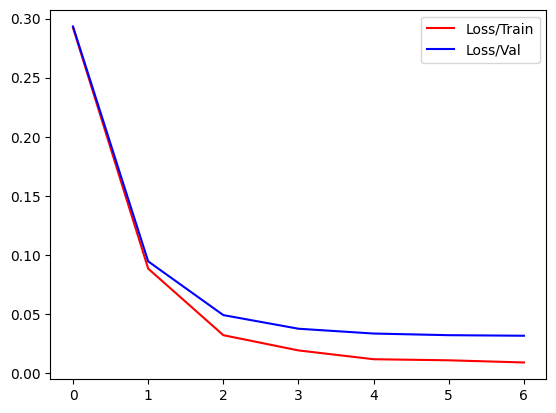

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(len(train_loss)), train_loss, c="r", label="Loss/Train")
plt.plot(np.arange(len(val_loss)), val_loss, c="b", label="Loss/Val")
plt.legend()

In [20]:
mean_acc = evaluate(state.params, test_loader)
print(f"Mean Accuracy: {mean_acc}")

  0%|          | 0/12 [00:00<?, ?it/s]

Mean Accuracy: 0.8997392654418945
